# Домашнее задание №3. Неопределенность оптимального портфеля. Оптимизация CVaR.
#### Выполнили: Мельников, Малышева, Селивановская

Целью работы является оценка неопределенности оптимального портфеля для нормального многомерного распределения и двух способов вычисления оптимального портфеля (оптимизация в модели Марковица и оптимизация CVaR)

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy
import math
import seaborn as sns
import warnings
from random import randint
from scipy.optimize import minimize
from matplotlib.ticker import ScalarFormatter
from scipy.spatial.distance import cityblock
from numpy import inf 
import pylab

warnings.filterwarnings('ignore')
from IPython.display import clear_output

#### Вспомогательные функции: 

In [2]:
# загрузка данных либо с yahoo finance, либо из локального файла
def download_data(tickers_list, year, local_file=False, dropna=True):
    if not local_file:
        data = yf.download(tickers_list, f'{year}-01-01',f'{year}-12-31') # ! 
    else:
        data = pd.read_pickle('ticker_data')
    
    if dropna:
        data.dropna(axis=1, inplace=True)    
    
    adj_close = data['Adj Close']    
    tickers = adj_close.columns
    dates = adj_close.index
    log_returns = pd.DataFrame(index=adj_close.index[1:], columns=adj_close.columns)
    
    for date_index in range(1, len(dates)):
        for ticker in tickers:
            prev_adj_close = adj_close.loc[dates[date_index - 1], ticker]
            curr_adj_close = adj_close.loc[dates[date_index], ticker]        
            log_returns.loc[dates[date_index], ticker] = np.log(curr_adj_close/prev_adj_close)
    
    return log_returns

# выборочные средние 
def calc_sample_means(returns):
    tickers = returns.columns # предполагаем, что первый столбец - дата 
    sample_means = pd.DataFrame(columns = ['Sample mean (E)'], index = tickers)
    for ticker in tickers:
        mean = np.mean(returns[ticker])
        sample_means['Sample mean (E)'][ticker] = mean
    return sample_means

# матрица выборочных ковариаций
def calc_sample_cov(returns, sample_means, verbose=True):
    tickers = returns.columns
    sample_cov = pd.DataFrame(columns = tickers, index = tickers)
    status_count = 0
    for ticker1 in tickers:    
        if verbose:
            status_count += 1
            clear_output()
            print(f"{status_count}/{len(tickers)}")

        for ticker2 in tickers:
            sum_ = 0
            N = returns[ticker2].shape[0] # количество наблюдений
            for i in range(N):
                sum_ += (returns[ticker1][i] - float(sample_means.loc[ticker1])) * (returns[ticker2][i] - float(sample_means.loc[ticker2]))

            sample_cov[ticker1][ticker2] = sum_ / (N)
    return sample_cov

# доходность портфеля
def calc_portfolio_return(x, means): 
    #E = sum(means.iloc[0:n_stocks] * x)
    #E = np.matmul(x, means)
    E = np.matmul(x, means.to_numpy())
    E = float(E)
    return E

# риск портфеля
def calc_portfolio_volatility(x, cov_matrix): 
    #sigma_sq = np.matmul(np.matmul(x, cov_matrix), x.T)
    sigma_sq = np.matmul(np.matmul(x, cov_matrix.to_numpy()), x.T)
    sigma_sq = float(sigma_sq)
    #return sigma_sq
    return sigma_sq**0.5 # !

# Относительная ошибка в норме Manhattan (cityblock)
def calc_relative_cityblock_error(vec_true, vec_pred):
    return cityblock(vec_true, vec_pred)/np.linalg.norm(vec_true)

## Подготовка модели.

Выберите на рынке 20 активов ($ N=20 $). По наблюдениям за 2019 год оцените математические ожидания доходностей и матрицу ковариаций доходностей (используйте выборочную матрицу ковариаций). Найденные вектор средних и матрица ковариаций будут далее использованы в экспериментах как «истинные» вектор $ E=(E_1, E_2, …, E_N) $ и матрица ковариаций $\sigma_{i, j}$. Убедитесь, что матрица ковариаций невырожденная (если она близка к вырожденной, то измените состав активов)


Опытным путем был найден список из 20 тикеров, с наименьшим числом обусловленности и ненулевым детерминантом матрицы ковариаций:

In [3]:
N = 20

tickers20 = ['ENOB', 'DORM', 'AVCO', 'ADMP', 'ICCC', 'CJJD', 'TUSK', 'LRMR', 'OSS', 'LFVN',
             'OTLK', 'DXLG', 'SYRS', 'EVOP', 'AEHR', 'SHEN', 'LOAN', 'CELC', 'SPI', 'RGCO']

log_returns = download_data(tickers20, year="2019")

#tickers20 = np.array(tickers20)
tickers20 = log_returns.columns # sorted 

[*********************100%***********************]  20 of 20 completed


#### Рассчитаем выборочные средние и выборочную матрицу ковариаций

In [4]:
means = calc_sample_means(log_returns)
cov_mat = calc_sample_cov(log_returns, means, verbose=True)

20/20


#### Проверим, является ли ковариционная матрица вырожденной и вычислим число обусловленности

In [5]:
det = np.linalg.det(cov_mat.to_numpy(dtype=float))
if det == 0:
    print("Матрица вырождена, det =", det)
else:
    print("Матрица невырождена, det =", det)
    
cond = np.linalg.cond(cov_mat.to_numpy(dtype=float))
print("Число обусловленности =", cond)

Матрица невырождена, det = 5.367040297402371e-57
Число обусловленности = 115.66559422369733


## 1. Истинный оптимальный портфель в модели Марковица с заданным отношением к риску.

Задана константа b. Решите задачу оптимизации

$$ \begin{cases}  
    -E(x) + b\sigma(x) \rightarrow  min \\
    \sum x_i = 1 \\ 
    x_i > 0 \quad \forall i
\end{cases} $$



(т.е. найдите оптимальный портфель с отношением к риску, равным b). Найдите и зафиксируйте веса портфеля и значение целевой функции.

Здесь 

$$E(x)= E_1x_1+E_2x_2+…+E_Nx_N,$$

$\sigma^2(x)=\sum\sum \sigma_{i, j} x_ix_j$

Комментарий: использовать solver задач оптимизации для общих целевых функций, так как $\sigma(x)= \sqrt{\sum\sum \sigma_{i, j} x_ix_j}$

### Примечание 1.
Константа b подобрана таким образом, что истинный оптимальный CVaR портфель совпадает с истинным оптимальным портфелем п.1. Значение константы смотри в упражнениях к теме
 
$ b = \frac{1}{\sqrt{2\pi}}\frac{1}{(1-\beta)}\exp{(\frac{-(\phi^{-1}(\beta))^2}{2}})$
 
 
Найдем константу $b$

In [6]:
beta = 0.95

b = 1/(((2*math.pi)**0.5)*(1 - beta)) * math.exp(-((scipy.stats.laplace.ppf(beta))**2)/2) # ?
b = 1/(((2*math.pi)**0.5)*(1 - beta)) * math.exp(-((scipy.stats.norm.ppf(beta))**2)/2) # ?
b

2.0627128075074257

### Найдем такой оптимальный портфель при найденном значении $b$ методом наименьших квадратов

In [7]:
def calc_utility_function(x, means, cov_mat, b):
    return -calc_portfolio_return(x, means) + b * calc_portfolio_volatility(x, cov_mat)

def find_optimal_portfolio(objective_function, args, n_stocks, decimals=4, short_sales=False): # x - weights of a portfolio
    # Генерация случайного начального решения 
    x_initial = np.random.random(n_stocks)
    #x_initial = np.ones(n_stocks)
    x_initial = x_initial/np.sum(x_initial) # нормализация
    x_initial = np.array(x_initial)
        
    # Ограничения     
    constraints = [{'type': 'eq',
                    'fun': lambda x: x.sum() - 1.0
                   }]
            
    # Ограничения на область значений x
    x_bounds = []
    if short_sales:
        # шорты разрешены, x принимает любое значение
        for i in range(n_stocks):
            x_bounds.append((None, None))
    else:
        # шорты запрещены, x принимает значение от 0 до 1
        for i in range(n_stocks):
            x_bounds.append((0, 1))        
  
    result = scipy.optimize.minimize(objective_function, # функция, которую хотим оптимизировать
                                     x_initial, # начальное решение 
                                     args=args, # дополнительные аргументы целевой функции
                                     method='SLSQP', # метод оптимизации (МНК)
                                     constraints=constraints, # ограничения 
                                     bounds=x_bounds, # ограничения на значения x
                                     options={'maxiter':1000, 'disp': False},
                                     tol=1e-15 # tolerance? somehow fixes the issue lol 1e-15
                                    )
    
    if result.success:
        return np.around(result.x, decimals=decimals), result.fun
    else:
        print("Couldn't find minimum")
        return

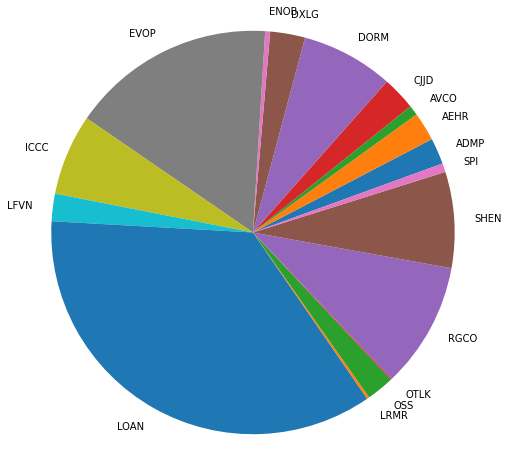

Оптимальный портфель с отношением к риску, равным 2.0627128075074257: 
ADMP    0.021
AEHR    0.023
AVCO    0.008
CELC    0.000
CJJD    0.027
DORM    0.074
DXLG    0.028
ENOB    0.004
EVOP    0.164
ICCC    0.065
LFVN    0.022
LOAN    0.355
LRMR    0.002
OSS     0.022
OTLK    0.001
RGCO    0.101
SHEN    0.077
SPI     0.007
SYRS    0.000
TUSK    0.000
dtype: float64
Значение целевой функции (-E(x)+ bσ(x)): 0.015916319746971608


In [8]:
x_opt, utility_function_opt = find_optimal_portfolio(calc_utility_function, 
                                                     (means, cov_mat, b), 
                                                     n_stocks=means.shape[0], 
                                                     decimals=3, 
                                                     short_sales=False)

# pie plot
fig1, ax1 = plt.subplots(figsize=(8, 8))
#print(np.where(x_opt != 0))
ax1.pie(x_opt[np.where(x_opt != 0)],
        labels=tickers20[np.where(x_opt != 0)],
        # autopct='%.2f%%',
        # shadow=True,
        startangle=20)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.title("Распределение весов в портфеле")
plt.show()

# prints
print(f"Оптимальный портфель с отношением к риску, равным {b}: \n{pd.Series(x_opt, index = tickers20)}")
print(f"Значение целевой функции (-E(x)+ bσ(x)): {utility_function_opt}")

## 2. Оценка неопределенности оптимального портфеля в модели Марковица с заданным отношением к риску.


### 2.1
Задайте число наблюдений $T=30$. С помощью генератора многомерного нормального распределения создайте выборку размера $Т$ из нормального распределения с вектором математических ожиданий $E=(E_1, E_2, …, E_N)$ и матрицей ковариаций $\sigma_{i, j}$.

In [9]:
def generate_random_log_returns(means, cov_mat, T=30, seed=42):
    np.random.seed(seed)
    r_sample30_log_returns = np.random.multivariate_normal(means.to_numpy(dtype=float).T[0], 
                                                           cov_mat.to_numpy(dtype=float), 
                                                           size=T) # генератор многомерного нормального распределения

    r_sample_log_returns = pd.DataFrame(data = r_sample30_log_returns, columns=tickers20)
    # r_sample is a random sample of log returns
    return r_sample_log_returns

In [10]:
r_sample30_log_returns = generate_random_log_returns(means, cov_mat, T=30, seed=69)
r_sample30_log_returns

,ADMP,AEHR,AVCO,CELC,CJJD,DORM,DXLG,ENOB,EVOP,ICCC,LFVN,LOAN,LRMR,OSS,OTLK,RGCO,SHEN,SPI,SYRS,TUSK
0,-0.012268,0.010754,-0.011759,0.021438,-0.021538,0.010331,0.014118,-0.049084,-0.033000,0.036479,0.056985,0.010336,-0.005861,0.049972,-0.117347,0.034617,0.037017,0.123696,0.033330,0.102486
1,-0.032755,-0.000854,-0.009494,-0.031471,0.018841,-0.028820,-0.034256,0.060880,-0.015069,0.034484,0.010866,0.000261,0.127171,0.051740,-0.173172,-0.032785,-0.028432,0.084262,-0.044780,0.108186
2,-0.008611,0.060795,0.036553,0.041173,-0.062091,-0.008561,0.061523,0.081186,0.053630,0.023454,-0.008674,0.010939,0.009768,0.000903,-0.147859,-0.018717,0.009832,-0.064056,0.011756,-0.073636
3,0.008579,-0.026874,0.149996,-0.043330,-0.024154,0.027821,0.020470,0.086659,-0.012324,-0.033370,-0.036483,0.008935,-0.054369,-0.088089,0.019899,-0.025880,-0.001521,0.057577,-0.046884,0.044811
4,0.095149,0.019506,-0.149359,-0.005448,0.078244,-0.001833,-0.035863,-0.055269,-0.004181,-0.065294,-0.006095,0.005606,-0.033995,0.029747,0.090455,0.025159,0.013343,0.187391,-0.001897,-0.155801
5,-0.055658,-0.064151,0.028731,0.054191,-0.063070,0.000123,0.041344,-0.029063,0.013575,-0.049668,0.035396,0.008449,0.023507,0.024674,0.058749,0.048134,0.040969,0.008214,-0.022033,0.014516
6,-0.028713,0.005346,0.231961,-0.074334,-0.071136,0.022470,0.027376,0.031123,-0.023899,-0.027383,0.000025,0.007259,-0.109436,-0.030089,-0.045395,-0.009019,0.017990,-0.167575,-0.001995,-0.056905
7,-0.088301,-0.027199,-0.125068,-0.022846,-0.012813,0.020847,-0.039364,0.051384,0.003535,-0.009752,0.010443,0.003462,-0.009533,-0.027992,-0.013594,-0.020527,0.014136,0.007025,0.014745,-0.089717
8,0.094598,-0.033326,-0.226810,-0.032197,0.032847,-0.013168,0.036433,0.050176,-0.002319,0.010727,0.025109,-0.002051,0.010011,0.063393,-0.049543,0.019430,0.024887,0.331232,-0.029860,0.040203
9,0.037156,-0.048701,0.125941,0.045896,-0.080107,0.014340,0.041629,0.022623,0.009718,-0.005494,0.022453,-0.022100,0.149629,-0.014374,0.122776,0.010183,0.022918,-0.204813,0.068705,0.077867


### 2.2. 
По построенной выборке сделайте оценку $E_{est}$ вектора математических ожиданий и оценку $(\sigma_{est(i, j)})$ матрицы ковариаций. 

In [11]:
r_sample30_means = calc_sample_means(r_sample30_log_returns) # E_est
r_sample30_cov_mat = calc_sample_cov(r_sample30_log_returns, r_sample30_means, verbose=True) # sigma_est

20/20


In [12]:
r_sample30_means

,Sample mean (E)
ADMP,-0.00160406
AEHR,-0.00910509
AVCO,-0.0104468
CELC,-0.00402068
CJJD,-0.00851185
DORM,-0.00291496
DXLG,-0.00250843
ENOB,0.012851
EVOP,-0.000671382
ICCC,-0.00590343


In [13]:
r_sample30_cov_mat

,ADMP,AEHR,AVCO,CELC,CJJD,DORM,DXLG,ENOB,EVOP,ICCC,LFVN,LOAN,LRMR,OSS,OTLK,RGCO,SHEN,SPI,SYRS,TUSK
ADMP,0.00376253,-0.000708077,0.00103642,0.000204576,0.000868563,-6.2465e-05,-6.10312e-05,-0.000587648,-9.49707e-05,-0.000468209,0.000371114,-0.000170772,9.63742e-05,0.000510686,0.0020375,3.58979e-05,-9.6168e-05,-2.45175e-05,-0.000438306,-0.000566915
AEHR,-0.000708077,0.00171024,-0.000304238,-0.000195948,0.00028924,-4.58004e-05,0.000505947,0.000162359,-2.62421e-05,4.29377e-05,-0.000280895,1.33319e-05,-0.000172125,-7.48912e-05,-0.00101805,3.94317e-05,-0.000176944,0.000911434,-0.000263809,0.000415265
AVCO,0.00103642,-0.000304238,0.0112731,0.000294529,-0.00173028,0.000568151,0.000238896,0.000115856,-0.000564208,-0.000275432,-2.62713e-05,-0.000265006,-0.000581098,-0.00104999,0.00165631,-0.000170357,-0.000231956,-0.00690714,-0.000204254,0.000721797
CELC,0.000204576,-0.000195948,0.000294529,0.00120722,-0.000184489,-3.18058e-05,0.000191107,0.000377772,0.000279137,0.000244809,0.000179936,7.14241e-05,0.000731714,0.000285055,0.00112103,0.000293518,7.00812e-05,-0.000868629,0.00102204,0.000478221
CJJD,0.000868563,0.00028924,-0.00173028,-0.000184489,0.00239203,-5.35743e-05,-0.000279384,-0.000204135,-0.000202126,-0.000268591,-4.39737e-05,-3.45634e-05,0.0001079,0.000339978,0.000166971,-0.000131368,-0.000375739,0.00128096,0.000242524,-0.000991457
DORM,-6.2465e-05,-4.58004e-05,0.000568151,-3.18058e-05,-5.35743e-05,0.000352995,-6.74248e-05,-0.000127099,-6.02207e-05,8.85423e-05,8.55434e-05,3.82302e-05,-0.000346687,-0.000274823,7.28304e-05,5.20496e-05,1.17032e-05,-0.000272241,0.000349986,-0.000131553
DXLG,-6.10312e-05,0.000505947,0.000238896,0.000191107,-0.000279384,-6.74248e-05,0.00170672,0.000963555,0.000115137,-0.000164334,0.00021121,-8.90995e-06,0.000659789,0.000118555,-0.00016195,5.9089e-05,0.000174779,0.000792934,-2.23053e-05,0.000787295
ENOB,-0.000587648,0.000162359,0.000115856,0.000377772,-0.000204135,-0.000127099,0.000963555,0.00361795,0.000398424,0.000701425,-9.32897e-05,0.000171026,0.000839763,8.87818e-05,0.000420717,-0.000101854,-1.997e-06,6.04023e-05,0.00051162,0.00087025
EVOP,-9.49707e-05,-2.62421e-05,-0.000564208,0.000279137,-0.000202126,-6.02207e-05,0.000115137,0.000398424,0.000389478,5.50452e-05,-1.67249e-05,6.13476e-05,0.000155272,-9.78316e-06,0.0005162,-1.21854e-06,5.94896e-05,1.68395e-05,0.000118834,-0.000250052
ICCC,-0.000468209,4.29377e-05,-0.000275432,0.000244809,-0.000268591,8.85423e-05,-0.000164334,0.000701425,5.50452e-05,0.00108161,0.000168341,0.000112391,0.000266256,0.000265883,-0.0011469,6.61788e-05,-1.27734e-05,0.000572428,0.000467872,0.00072937


## 2.3 
Используя эти оценки решите задачу оптимизации

$\begin{cases}  
    -E_{est}(x) + b\sigma_{est}(x) \rightarrow  min \\
    \sum x_i = 1 \\ 
    x_i \ge 0 \quad \forall i
\end{cases}$

Здесь 

$E_{est}(x)= E_{est1}x_1+ E_{est2}x_2+…+ E_{estN}x_N ,$ 

$\sigma_{est}^2(x) =\sum\sum \sigma_{est (i, j)} x_ix_j$

(т.е. найдите выборочный оптимальный портфель с отношением к риску, равным b). Найдите и зафиксируйте веса портфеля и значение целевой функции.


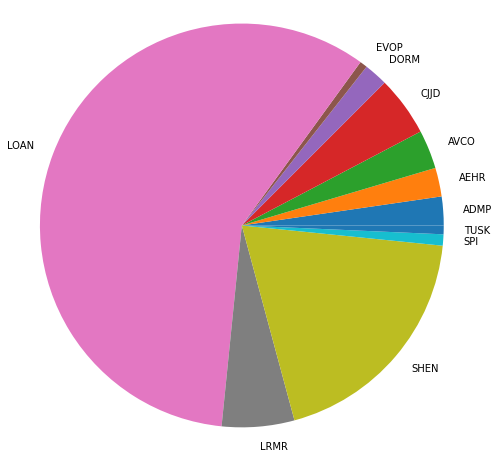

Оптимальный портфель с отношением к риску, равным 2.0627128075074257: 
ADMP    0.023
AEHR    0.023
AVCO    0.031
CELC    0.000
CJJD    0.048
DORM    0.019
DXLG    0.000
ENOB    0.000
EVOP    0.006
ICCC    0.000
LFVN    0.000
LOAN    0.584
LRMR    0.058
OSS     0.000
OTLK    0.000
RGCO    0.000
SHEN    0.192
SPI     0.009
SYRS    0.000
TUSK    0.007
dtype: float64
Значение целевой функции (-E(x)+ bσ(x)): 0.00980550648889593


In [14]:
x_opt_r_sample30, utility_function_opt_r_sample30 = find_optimal_portfolio(calc_utility_function, 
                                                     (r_sample30_means, r_sample30_cov_mat, b), 
                                                     n_stocks=r_sample30_means.shape[0], 
                                                     decimals=3, 
                                                     short_sales=False)

# pie plot
fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(x_opt_r_sample30[np.where(x_opt_r_sample30 != 0)],
        labels=tickers20[np.where(x_opt_r_sample30 != 0)],
        # autopct='%.2f%%',
        # shadow=True,
        startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.title("Распределение весов в портфеле")
plt.show()

# prints
print(f"Оптимальный портфель с отношением к риску, равным {b}: \n{pd.Series(x_opt_r_sample30, index = tickers20)}")
print(f"Значение целевой функции (-E(x)+ bσ(x)): {utility_function_opt_r_sample30}")

### 2.4 
Сравните два портфеля: истинный (п.1) и выборочный (п.2.3). Оцените относительную ошибку в определении весов портфеля в норме Manhattan (L1 норма Минковского). Сделайте выводы. Сделайте сравнение в системе координат $(\sigma, E)$. 

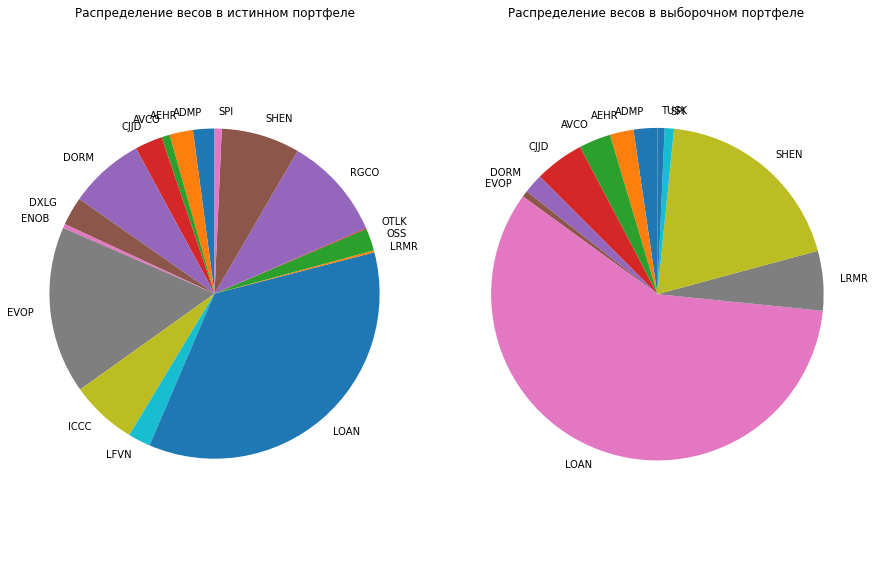

In [15]:
# pie plot
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].pie(x_opt[np.where(x_opt != 0)],
        labels=tickers20[np.where(x_opt != 0)],
        # autopct='%.2f%%',
        # shadow=True,
        startangle=90)
axs[0].axis('equal')
axs[0].set_title("Распределение весов в истинном портфеле")

axs[1].pie(x_opt_r_sample30[np.where(x_opt_r_sample30 != 0)],
        labels=tickers20[np.where(x_opt_r_sample30 != 0)],
        # autopct='%.2f%%',
        # shadow=True,
        startangle=90)
axs[1].axis('equal') 
axs[1].set_title("Распределение весов в выборочном портфеле")

plt.subplots_adjust(right=1.25)
#plt.title("Сравнение истинного и выборочного портфелей")
plt.show()

Относительная ошибка в норме Manhattan составляет: 2.1334426576297565


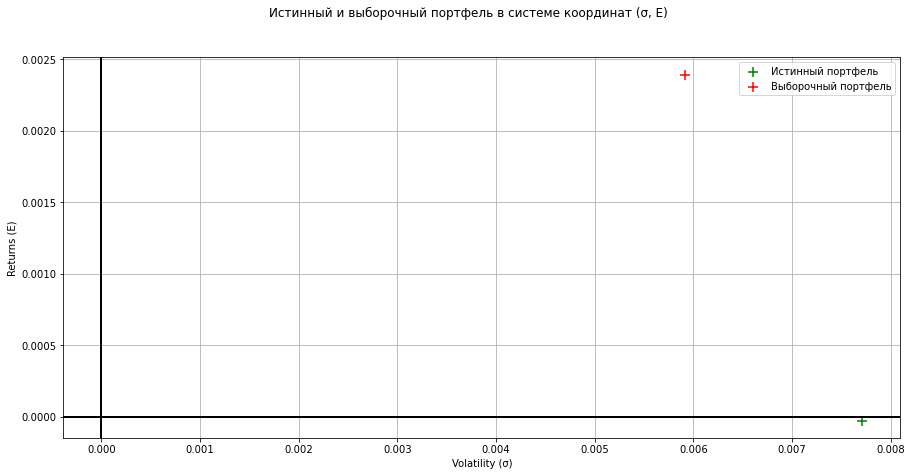

In [16]:
# расчеты доходности и риска
x_opt_return = calc_portfolio_return(x_opt, means)
x_opt_volatility = calc_portfolio_volatility(x_opt, cov_mat)

x_opt_r_sample30_return = calc_portfolio_return(x_opt_r_sample30, r_sample30_means)
x_opt_r_sample30_volatility = calc_portfolio_volatility(x_opt_r_sample30, r_sample30_cov_mat)

# plots
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Истинный и выборочный портфель в системе координат (σ, E)")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

ax.scatter(x_opt_volatility, x_opt_return, color="g", marker="+", s=100, label="Истинный портфель")    
ax.scatter(x_opt_r_sample30_volatility, x_opt_r_sample30_return, color="r", marker="+", s=100, label="Выборочный портфель")       

ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()

# manhattan error
print("Относительная ошибка в норме Manhattan составляет:", calc_relative_cityblock_error(x_opt, x_opt_r_sample30))

### 2.5. 
Повторите эксперимент $S=40$ раз и оцените среднюю относительную ошибку по $S$ повторениям эксперимента. Сделайте выводы.  Сделайте сравнение в системе координат $(\sigma, E)$. 

20/20
Средняя относительная ошибка по 40 повторениям эксперимента: 1.4186456925638482


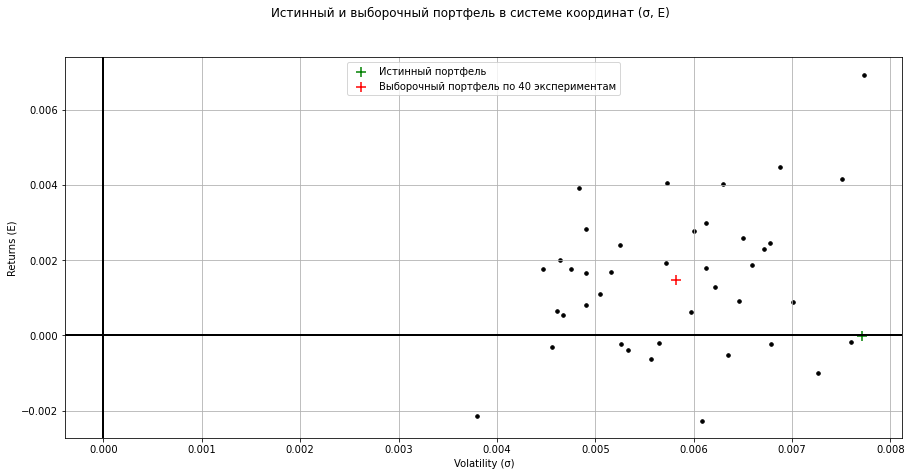

In [17]:
S = 40
# plot
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Истинный и выборочный портфель в системе координат (σ, E)")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')
ax.scatter(x_opt_volatility, x_opt_return, color="g", marker="+", s=100, label="Истинный портфель")      

# main loop
x_opt_r_sample_all = [] # оптимальные портфели для каждого из S экспериментов 
rel_errors = [] # относительные ошибки
x_opt_r_sample_returns = [] # доходность каждого из S портфелей
x_opt_r_sample_volatilities = [] # риск каждого из S портфелей

for i in range(S):
    # r_sample name is used exclusively in this loop
    
    # generate random log returns:
    r_sample_log_returns = generate_random_log_returns(means, cov_mat, T=30, seed=i) 
    
    # calculate sample means and sample covariance matrix
    r_sample_means = calc_sample_means(r_sample_log_returns) # E_est
    r_sample_cov_mat = calc_sample_cov(r_sample_log_returns, r_sample_means, verbose=True) # sigma_est
    
    # find optimal portfolio
    x_opt_r_sample, utility_function_opt_r_sample = find_optimal_portfolio(calc_utility_function, 
                                                     (r_sample_means, r_sample_cov_mat, b), 
                                                     n_stocks=r_sample_means.shape[0], 
                                                     decimals=3, 
                                                     short_sales=False)
    
    # calculate and store the value of error
    rel_errors.append(calc_relative_cityblock_error(x_opt, x_opt_r_sample)) 
    
    # store return and volatility of an optimal portfolio
    x_opt_r_sample_returns.append(calc_portfolio_return(x_opt_r_sample, r_sample_means))
    x_opt_r_sample_volatilities.append(calc_portfolio_volatility(x_opt_r_sample, r_sample_cov_mat))
    
    # I don't really remember
    x_opt_r_sample_all.append(np.array(x_opt_r_sample))    
    
    # plot
    ax.scatter(x_opt_r_sample_volatilities[i], x_opt_r_sample_returns[i], 
           color="black", marker=".", s=50) # label?
    
x_opt_r_sample_all = np.array(x_opt_r_sample_all)

# plot
ax.scatter(np.array(x_opt_r_sample_volatilities).mean(), np.array(x_opt_r_sample_returns).mean(), 
           color="red", marker="+", s=100, label=f"Выборочный портфель по {S} экспериментам")

ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()

first_error = np.array(rel_errors).mean()
print(f"Средняя относительная ошибка по {S} повторениям эксперимента: {np.array(rel_errors).mean()}")

### 2.6  
Предположите, что нам известны точные значения математических ожиданий $E=(E_1, E_2, …, E_N)$. Повторите пп. 2.2-2.5. используя оценку только матрицы ковариаций (т.е. решайте задачу оптимизации 

$\begin{cases}  
    -E(x) + b\sigma_{est}(x) \rightarrow  min \\
    \sum x_i = 1 \\ 
    x_i \ge 0 \quad \forall i
\end{cases}$

Здесь 

$E(x)= E_1x_1+E_2x_2+…+E_Nx_N, $

$\sigma_{est}^2(x) =\sum\sum \sigma_{est (i, j)} x_ix_j$ )

Сравните точность этих портфелей и портфелей п.2.3


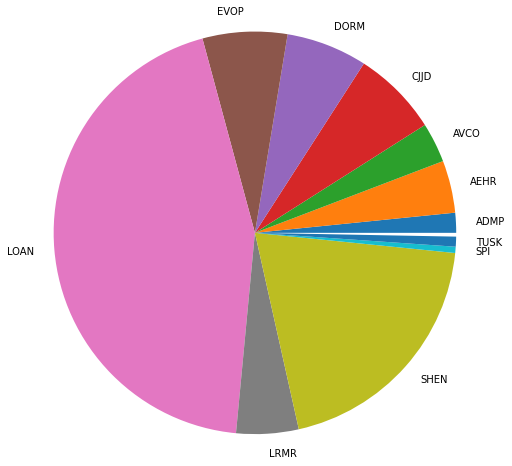

Оптимальный портфель с отношением к риску, равным 2.0627128075074257: 
ADMP    0.023
AEHR    0.023
AVCO    0.031
CELC    0.000
CJJD    0.048
DORM    0.019
DXLG    0.000
ENOB    0.000
EVOP    0.006
ICCC    0.000
LFVN    0.000
LOAN    0.584
LRMR    0.058
OSS     0.000
OTLK    0.000
RGCO    0.000
SHEN    0.192
SPI     0.009
SYRS    0.000
TUSK    0.007
dtype: float64
Значение целевой функции (-E(x)+ b_est(x)): 0.011716326373983423


In [18]:
x_opt_r_sample30_2, utility_function_opt_r_sample30_2 = find_optimal_portfolio(calc_utility_function, 
                                                     (means, r_sample30_cov_mat, b), 
                                                     n_stocks=means.shape[0], 
                                                     decimals=3, 
                                                     short_sales=False)

# pie plot
fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.pie(x_opt_r_sample30_2[np.where(x_opt_r_sample30 != 0)],
        labels=tickers20[np.where(x_opt_r_sample30 != 0)],
        # autopct='%.2f%%',
        # shadow=True,
        startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.title("Распределение весов в портфеле")
plt.show()

# prints
print(f"Оптимальный портфель с отношением к риску, равным {b}: \n{pd.Series(x_opt_r_sample30, index = tickers20)}")
print(f"Значение целевой функции (-E(x)+ b_est(x)): {utility_function_opt_r_sample30_2}")

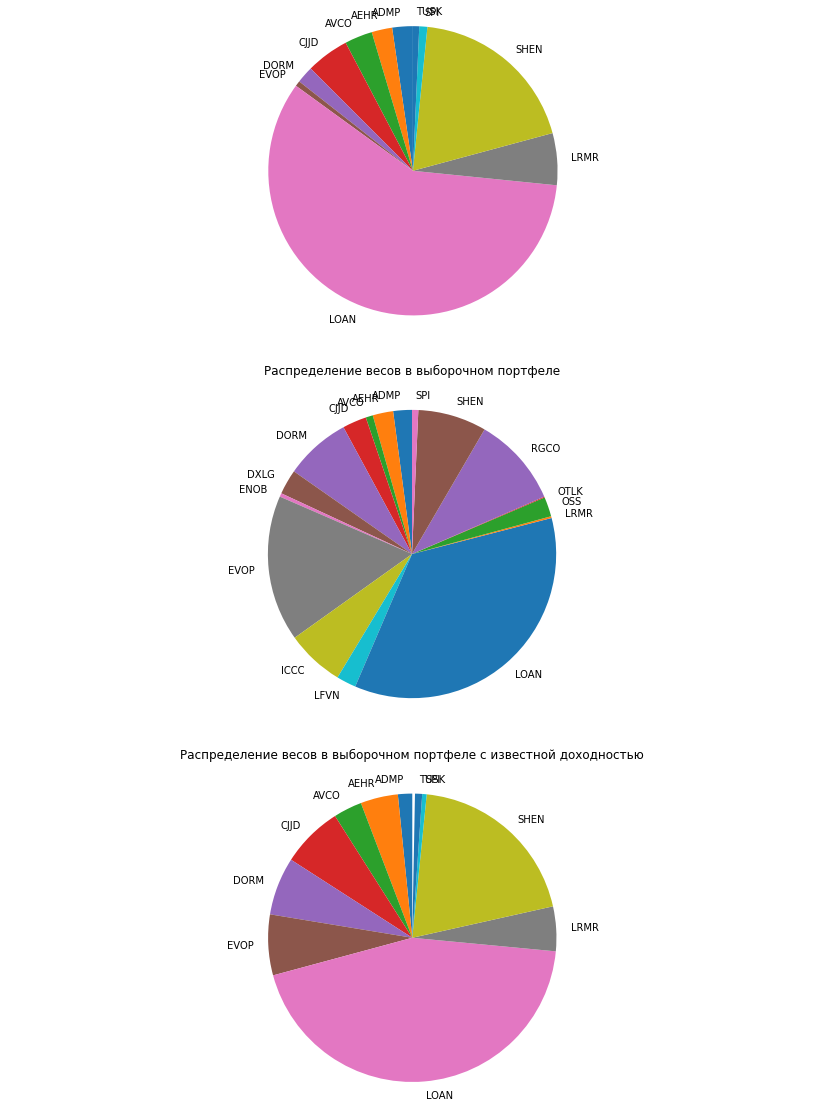

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(10, 20))


axs[1].pie(x_opt[np.where(x_opt != 0)],
        labels=tickers20[np.where(x_opt != 0)],
        # autopct='%.2f%%',
        # shadow=True,
        startangle=90)
axs[1].axis('equal')
axs[1].set_title("Распределение весов в истинном портфеле\n")

axs[0].pie(x_opt_r_sample30[np.where(x_opt_r_sample30 != 0)],
        labels=tickers20[np.where(x_opt_r_sample30 != 0)],
        # autopct='%.2f%%',
        # shadow=True,
        startangle=90)
axs[0].axis('equal') 
axs[1].set_title("Распределение весов в выборочном портфеле\n")

axs[2].pie(x_opt_r_sample30_2[np.where(x_opt_r_sample30 != 0)],
        labels=tickers20[np.where(x_opt_r_sample30 != 0)],
        # autopct='%.2f%%',
        # shadow=True,
        startangle=90)
axs[2].axis('equal') 
axs[2].set_title("Распределение весов в выборочном портфеле c известной доходностью\n")

plt.subplots_adjust(right=1.25)
#plt.title("Сравнение истинного и выборочного портфелей")
plt.show()

Относительная ошибка в норме Manhattan составляет: 1.6486757749411074


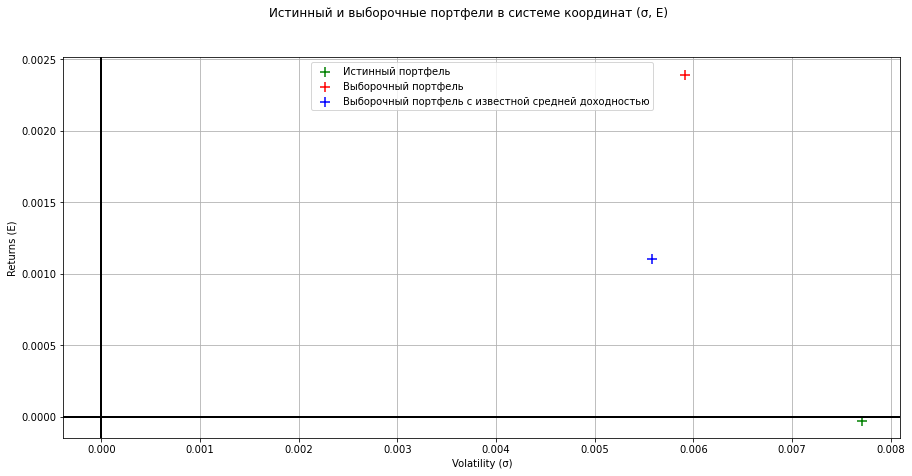

In [20]:
# расчеты доходности и риска
x_opt_r_sample30_return_2 = calc_portfolio_return(x_opt_r_sample30_2, r_sample30_means)
x_opt_r_sample30_volatility_2 = calc_portfolio_volatility(x_opt_r_sample30_2, r_sample30_cov_mat)

# plots
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Истинный и выборочные портфели в системе координат (σ, E)")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

ax.scatter(x_opt_volatility, x_opt_return, color="g", marker="+", s=100, label="Истинный портфель")    
ax.scatter(x_opt_r_sample30_volatility, x_opt_r_sample30_return, color="r", marker="+", s=100, label="Выборочный портфель")       
ax.scatter(x_opt_r_sample30_volatility_2, x_opt_r_sample30_return_2, color="blue", marker="+", s=100, label="Выборочный портфель c известной средней доходностью")       

ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()

# manhattan error
print("Относительная ошибка в норме Manhattan составляет:", calc_relative_cityblock_error(x_opt, x_opt_r_sample30_2))

20/20
Средняя относительная ошибка по 40 повторениям эксперимента для выборочного портфеля: 1.4186456925638482  
Средняя относительная ошибка по 40 повторениям эксперимента для выборочного портфеля с известной доходностью: 1.3941731615295663  


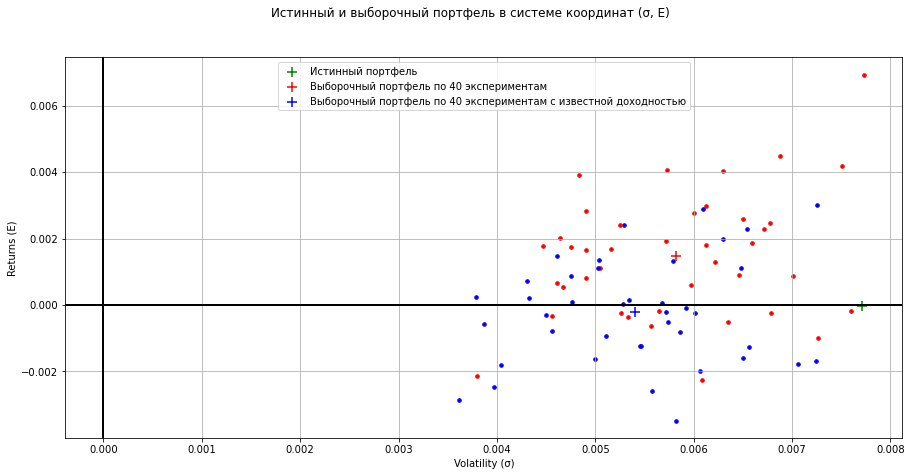

In [21]:
S = 40
# plot
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Истинный и выборочный портфель в системе координат (σ, E)")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')
ax.scatter(x_opt_volatility, x_opt_return, color="g", marker="+", s=100, label="Истинный портфель")      

# main loop
x_opt_r_sample_all = [] # оптимальные портфели для каждого из S экспериментов 
rel_errors = [] # относительные ошибки
x_opt_r_sample_returns = [] # доходность каждого из S портфелей
x_opt_r_sample_volatilities = [] # риск каждого из S портфелей

x_opt_r_sample_all_2 = []  
rel_errors_2 = [] 
x_opt_r_sample_returns_2 = [] 
x_opt_r_sample_volatilities_2 = [] 

for i in range(S):
    # r_sample name is used exclusively in this loop
    
    # generate random log returns:
    r_sample_log_returns = generate_random_log_returns(means, cov_mat, T=30, seed=i) 
    
    # calculate sample means and sample covariance matrix
    r_sample_means = calc_sample_means(r_sample_log_returns) # E_est
    r_sample_cov_mat = calc_sample_cov(r_sample_log_returns, r_sample_means, verbose=True) # sigma_est
    
    # find optimal portfolio
    x_opt_r_sample, utility_function_opt_r_sample = find_optimal_portfolio(calc_utility_function, 
                                                     (r_sample_means, r_sample_cov_mat, b), 
                                                     n_stocks=r_sample_means.shape[0], 
                                                     decimals=3, 
                                                     short_sales=False)
    x_opt_r_sample_2, utility_function_opt_r_sample_2 = find_optimal_portfolio(calc_utility_function, 
                                                     (means, r_sample_cov_mat, b), 
                                                     n_stocks=r_sample_means.shape[0], 
                                                     decimals=3, 
                                                     short_sales=False)
    
    # calculate and store the value of error
    rel_errors.append(calc_relative_cityblock_error(x_opt, x_opt_r_sample)) 
    rel_errors_2.append(calc_relative_cityblock_error(x_opt, x_opt_r_sample_2)) 

    # store return and volatility of an optimal portfolio
    x_opt_r_sample_returns.append(calc_portfolio_return(x_opt_r_sample, r_sample_means))
    x_opt_r_sample_volatilities.append(calc_portfolio_volatility(x_opt_r_sample, r_sample_cov_mat))
    
    x_opt_r_sample_returns_2.append(calc_portfolio_return(x_opt_r_sample_2, r_sample_means))
    x_opt_r_sample_volatilities_2.append(calc_portfolio_volatility(x_opt_r_sample_2, r_sample_cov_mat))
    # I don't really remember
    x_opt_r_sample_all.append(np.array(x_opt_r_sample))    
    x_opt_r_sample_all_2.append(np.array(x_opt_r_sample_2))    

    
    # plot
    ax.scatter(x_opt_r_sample_volatilities[i], x_opt_r_sample_returns[i], 
           color="red", marker=".", s=50) # label?
    ax.scatter(x_opt_r_sample_volatilities_2[i], x_opt_r_sample_returns_2[i], 
       color="blue", marker=".", s=50)
    
x_opt_r_sample_all = np.array(x_opt_r_sample_all)
x_opt_r_sample_all_2 = np.array(x_opt_r_sample_all_2)
# plot
ax.scatter(np.array(x_opt_r_sample_volatilities).mean(), np.array(x_opt_r_sample_returns).mean(), 
           color="red", marker="+", s=100, label=f"Выборочный портфель по {S} экспериментам")
ax.scatter(np.array(x_opt_r_sample_volatilities_2).mean(), np.array(x_opt_r_sample_returns_2).mean(), 
           color="blue", marker="+", s=100, label=f"Выборочный портфель по {S} экспериментам c известной доходностью")
ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()

print(f"Средняя относительная ошибка по {S} повторениям эксперимента для выборочного портфеля: {np.array(rel_errors).mean()}  ")
print(f"Средняя относительная ошибка по {S} повторениям эксперимента для выборочного портфеля с известной доходностью: {np.array(rel_errors_2).mean()}  ")

## 3. Оценка неопределенности оптимального CVaR портфеля 

### 3.1 
Уровень значимости $β$ выбран $0,95$. Число наблюдений $T$. Используя сгенерированные наблюдения из п.2.1 решите задачу ЛП для определения оптимального $CVaRβ$ портфеля.  Найдите и зафиксируйте веса портфеля и значение целевой функции $CVaR$.  

In [22]:
returns30 = r_sample30_log_returns.to_numpy() #sample generated in task 2.1
T = returns30.shape[0]
N = returns30.shape[1]
beta = 0.95 #significance level

def obj_func(vec_ut_x_alpha, T, beta):
    return vec_ut_x_alpha[N+T] + 1/(T-T*beta)*np.sum(vec_ut_x_alpha[:T])

def func(vec_ut_x_alpha, returns30, t): #RX + alpha + ut
    RX = np.dot(returns30[t], vec_ut_x_alpha[T:N+T])
    return RX + vec_ut_x_alpha[N+T] + vec_ut_x_alpha[t]

def CVaR_optimization(beta, returns30, func):
    alpha  = 0 
    x = np.ones(N)/N
    ut = - np.dot(returns30,  x) - alpha #dummy variables
    
    vec_ut_x_alpha = np.zeros(N+T+1)
    vec_ut_x_alpha[:T] = ut
    vec_ut_x_alpha[T:N+T] = x
    vec_ut_x_alpha[N+T] = alpha
    
    alpha_bound = ((-inf, inf),)
    x_bound = ((0, 1.1),)*N 
    ut_bound = ((0, inf),)*T 
    
    constraints = list()
    constraints.append({'type': 'eq', 'fun': lambda x: sum(x[T:N+T])-1}) #sum(xi) = 1
    
    for t in range(0, T):
        constraints.append({'type': 'ineq', 'fun': func, 'args': (returns30, t)}) #RX + alpha + ut >= 0

    return minimize(obj_func, vec_ut_x_alpha, args=(T, beta), method='SLSQP', #МНК
                    constraints=constraints, bounds=ut_bound+x_bound+alpha_bound).x

In [23]:
ans = CVaR_optimization(beta, returns30, func)
weights_cvar = ans[T:N+T]
cvar_alpha  = round(ans[N+T], 5)

Распределение весов, в получившемся портфеле:

In [24]:
weights_cvar

array([6.76142522e-02, 0.00000000e+00, 2.57019137e-16, 0.00000000e+00,
       1.06683097e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.50001014e-16, 2.12476954e-15, 4.52424186e-01,
       8.07639243e-03, 2.60795532e-03, 0.00000000e+00, 7.69466015e-02,
       2.60025370e-01, 0.00000000e+00, 1.16923504e-15, 2.56221460e-02])

In [25]:
print('Alpha полученного CVaR портфеля:' , cvar_alpha)

Alpha полученного CVaR портфеля: 0.00612


Теперь посчитаем VaR полученного портфеля на уровне доверия 0.95:

In [26]:
level = 0.95
losses = -np.dot(returns30, weights_cvar)
VaR = np.quantile(losses, level)
print('Потери не превысят %.5f с уверенностью %.f%s' % (np.round(VaR,5), level*100 , '%'))

Потери не превысят 0.00612 с уверенностью 95%


#### Визуализируем распределение весов между компаниями в этом портфеле:

In [27]:
def weights_visualization(weights, title):
    weights_data = pd.DataFrame(index = tickers20, columns = ['weight'])
    weights_data['weight'] = weights

    plt.figure(figsize = (13,6))
    x = np.arange(weights_data.shape[0])
    x_values = weights_data.index
    plt.xlabel('Акция', fontsize = 13)
    plt.ylabel('Вес', fontsize = 13)
    plt.bar(x, height = weights_data['weight'], color='teal')
    plt.xticks(x, x_values, rotation='50')
    plt.yscale("log")
    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.title(title, fontsize = 14)
    plt.grid()

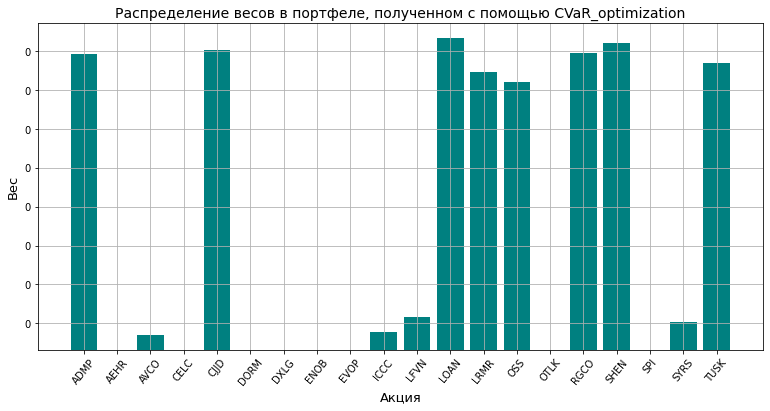

In [28]:
weights_visualization(weights_cvar, "Распределение весов в портфеле, полученном с помощью CVaR_optimization")

### 3.2 
Сравните два портфеля: истинный (п.1) и найденный в п.3.1.  Оцените относительную ошибку в определении весов портфеля в норме Manhattan (L1 норма Минковского). Сравните с ошибкой портфеля из п. 2.3

#### Визуализируем распределение весов истинном портфеле (получен в п.1):

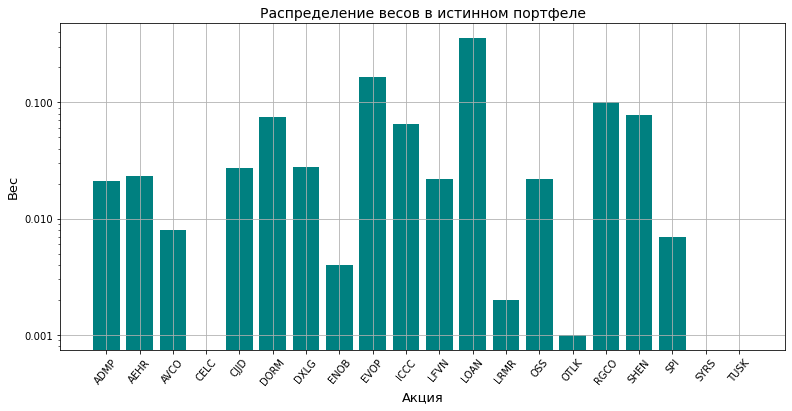

In [29]:
weights_visualization(x_opt, "Распределение весов в истинном портфеле")

#### Распределение весов в выборочном оптимальном портфеле из пункта 2.3:

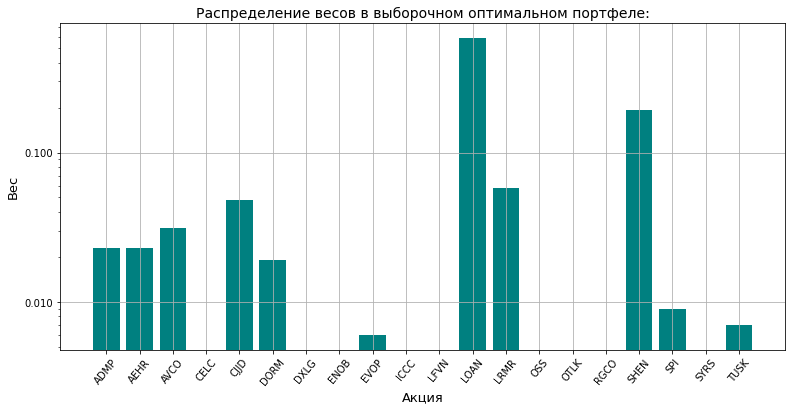

In [30]:
weights_visualization(x_opt_r_sample30 , "Распределение весов в выборочном оптимальном портфеле:")

#### Оценим относительную ошибку в определении весов этих двух портфелей в норме Manhattan (L1 норма Минковского):

In [31]:
norm1 = np.around(np.linalg.norm(x_opt - x_opt_r_sample30, ord = 1), 5)
norm2 = np.around(np.linalg.norm(x_opt - weights_cvar, ord = 1), 5)
print('Норма Manhattan для портфеля из п.2.3 :', norm1)
print('Норма Manhattan для портфеля, полученного с помощью CVaR_optimization:', norm2)

Норма Manhattan для портфеля из п.2.3 : 0.911
Норма Manhattan для портфеля, полученного с помощью CVaR_optimization: 0.87789


#### Изобразим портфели на карте активов:

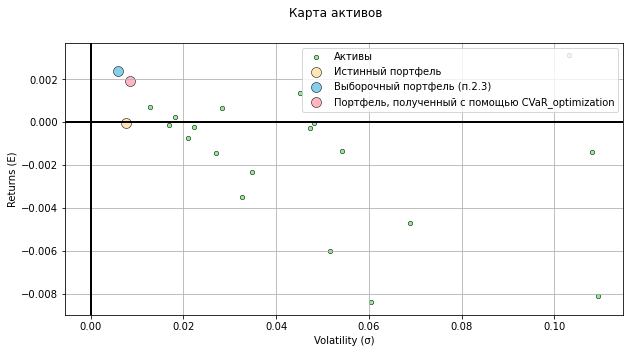

In [32]:
#Координаты для активов
sample_stds = np.diag(cov_mat)**0.5
sample_means = calc_sample_means(log_returns)
#Координаты для истинного портфеля
E_x_opt = calc_portfolio_return(x_opt, means)
std_x_opt = calc_portfolio_volatility(x_opt, cov_mat)
#Координаты для выборочного оптимального портфеля из п.2.3
E_x_opt_r_sample30 = calc_portfolio_return(x_opt_r_sample30, r_sample30_means)
std_x_opt_r_sample30 = calc_portfolio_volatility(x_opt_r_sample30, r_sample30_cov_mat)
#Координаты для портфеля, полученного с помощью CVaR_optimization
E_weights_cvar = calc_portfolio_return(weights_cvar, r_sample30_means)
std_weights_cvar = calc_portfolio_volatility(weights_cvar, r_sample30_cov_mat)

#График
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Карта активов")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')

ax.scatter(sample_stds, sample_means, marker="o", 
           color='lightgreen', edgecolors= 'black', linewidth=0.5, s=20, label='Активы')
ax.scatter(std_x_opt, E_x_opt, marker="o", color='moccasin',
           edgecolors= 'black', linewidth=0.5, s=100, label="Истинный портфель")
ax.scatter(std_x_opt_r_sample30, E_x_opt_r_sample30, marker="o", color='skyblue',
           edgecolors= 'black', linewidth=0.5, s=100, label="Выборочный портфель (п.2.3)")
ax.scatter(std_weights_cvar, E_weights_cvar, marker="o", color='lightpink',
           edgecolors= 'black', linewidth=0.5, s=100, label="Портфель, полученный с помощью CVaR_optimization")

ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()

Норма Manhattan для СVaR портфеля меньше, чем норма для выборочного портфеля из п.2.3. Исходя из этого можно сделать вывод, что портфель, полученный с помощью CVaR_optimization, ближе к истинному. На карте активов это также заметно.

### 3.3. 
Повторите эксперимент $S$ раз и оцените среднюю относительную ошибку по S повторениям эксперимента. Сделайте выводы.  Сравните с ошибкой из п. 2.5 

20/20
Средняя относительная ошибка по 40 повторениям эксперимента CVaR портфеля: 1.9593830555902596  
Средняя относительная ошибка по 40 повторениям эксперимента из 2.5: 1.4186456925638482  


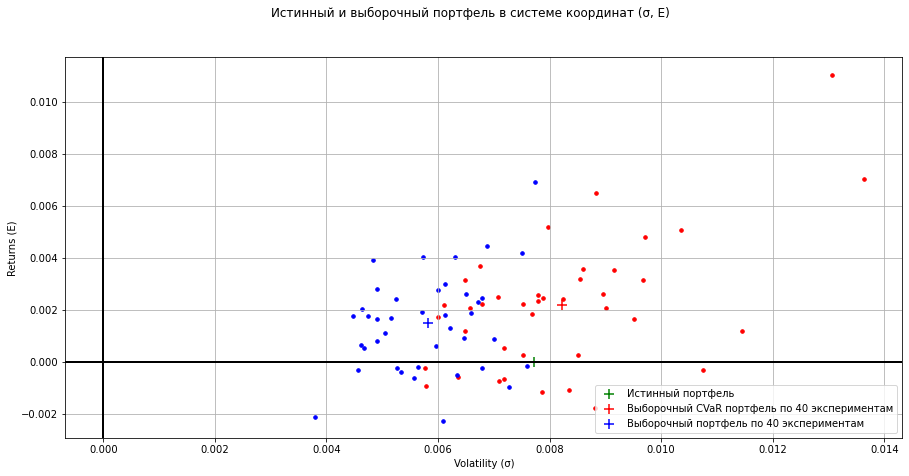

In [35]:
S = 40
# plot
fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Истинный и выборочный портфель в системе координат (σ, E)")
ax.axhline(linewidth=2, color='black')
ax.axvline(linewidth=2, color='black')
ax.scatter(x_opt_volatility, x_opt_return, color="g", marker="+", s=100, label="Истинный портфель")      

# main loop
x_opt_r_sample_all = [] # оптимальные портфели для каждого из S экспериментов 
rel_errors = [] # относительные ошибки
x_opt_r_sample_returns = [] # доходность каждого из S портфелей
x_opt_r_sample_volatilities = [] # риск каждого из S портфелей

x_opt_r_sample_all_2 = []  
rel_errors_2 = [] 
x_opt_r_sample_returns_2 = [] 
x_opt_r_sample_volatilities_2 = [] 
for i in range(S):

    r_sample_log_returns = generate_random_log_returns(means, cov_mat, T=30, seed=i) 
    returns30 = r_sample_log_returns.to_numpy()
    ans = CVaR_optimization(beta, returns30, func)
    x_opt_r_sample = ans[T:N+T]
    cvar_alpha  = round(ans[N+T], 5)

    
    # calculate sample means and sample covariance matrix
    r_sample_means = calc_sample_means(r_sample_log_returns) # E_est
    r_sample_cov_mat = calc_sample_cov(r_sample_log_returns, r_sample_means, verbose=True) # sigma_est
    
    # find optimal portfolio
    x_opt_r_sample_2, utility_function_opt_r_sample = find_optimal_portfolio(calc_utility_function, 
                                                     (r_sample_means, r_sample_cov_mat, b), 
                                                     n_stocks=r_sample_means.shape[0], 
                                                     decimals=3, 
                                                     short_sales=False)


    
    r_sample_means = calc_sample_means(r_sample_log_returns) 
    r_sample_cov_mat = calc_sample_cov(r_sample_log_returns, r_sample_means, verbose=True) 
        
    # calculate and store the value of error
    rel_errors.append(calc_relative_cityblock_error(x_opt, x_opt_r_sample)) 
    rel_errors_2.append(calc_relative_cityblock_error(x_opt, x_opt_r_sample_2)) 

    # store return and volatility of an optimal portfolio
    x_opt_r_sample_returns.append(calc_portfolio_return(x_opt_r_sample, r_sample_means))
    x_opt_r_sample_volatilities.append(calc_portfolio_volatility(x_opt_r_sample, r_sample_cov_mat))
    
    x_opt_r_sample_returns_2.append(calc_portfolio_return(x_opt_r_sample_2, r_sample_means))
    x_opt_r_sample_volatilities_2.append(calc_portfolio_volatility(x_opt_r_sample_2, r_sample_cov_mat))
    
    # I don't really remember
    x_opt_r_sample_all.append(np.array(x_opt_r_sample))  
    x_opt_r_sample_all_2.append(np.array(x_opt_r_sample_2))    
    
    # plot
    ax.scatter(x_opt_r_sample_volatilities[i], x_opt_r_sample_returns[i], 
           color="red", marker=".", s=50) # label?
    ax.scatter(x_opt_r_sample_volatilities_2[i], x_opt_r_sample_returns_2[i], 
       color="blue", marker=".", s=50)
    
x_opt_r_sample_all = np.array(x_opt_r_sample_all)
x_opt_r_sample_all_2 = np.array(x_opt_r_sample_all_2)

# plot
ax.scatter(np.array(x_opt_r_sample_volatilities).mean(), np.array(x_opt_r_sample_returns).mean(), 
           color="red", marker="+", s=100, label=f"Выборочный CVaR портфель по {S} экспериментам")
ax.scatter(np.array(x_opt_r_sample_volatilities_2).mean(), np.array(x_opt_r_sample_returns_2).mean(), 
           color="blue", marker="+", s=100, label=f"Выборочный портфель по {S} экспериментам")
ax.set_xlabel("Volatility (σ)")
ax.set_ylabel("Returns (E)")
ax.grid()
ax.legend()
fig.show()

print(f"Средняя относительная ошибка по {S} повторениям эксперимента CVaR портфеля: {np.array(rel_errors).mean()}  ")
print(f"Средняя относительная ошибка по {S} повторениям эксперимента из 2.5: {np.array(rel_errors_2).mean()}  ")
